Load Data

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

folder = os.path.join("..", "0_dataset", "lifecycle")
models_folder = "models_lifecycle"
# folder = os.path.join("..", "0_dataset", "syslog")
# models_folder = "models_log"

def load_X(type_X):
    filename = 'lifecycle_dataset_'+type_X+'.csv'
    # filename = 'fix_original_label_syslog.csv'
    df = pd.read_csv(os.path.join(folder, filename))
    # print(df.info)
    
    X = df['lifecycle']
    # X = df['EventTemplate']
    X = X.to_numpy()
    for i, seq in enumerate(X):
        X[i] = seq.strip(']').strip('[').split(',')
        # max_seq_length = max(max_seq_length, len(X[i]) + 1)
    
    return X

def load_y(type_y):
    filename = 'lifecycle_dataset_'+type_y+'.csv'
    # filename = 'fix_original_label_syslog.csv'
    df = pd.read_csv(os.path.join(folder, filename))
    
    y = df['Label']
    y = y.to_numpy()
    y = y.reshape(-1)
    
    return y

# X_train = load_X('train')
# X_test = load_X('test')
# y_train = load_y('train')
# y_test = load_y('test')

# X = load_X('35')
# y = load_y('35')

X = load_X('train')
y = load_y('train')

# print(X)
# print(y)

# # build labeling map
# le = preprocessing.LabelEncoder()
# le.fit(y)
# origin_to_transformed = dict(zip(le.classes_, le.transform(le.classes_)))
# transformed_to_origin = dict(zip(le.transform(le.classes_), le.classes_))

# # logs setting (label encoding)
# label_original = sorted(np.unique(y))
# tech_size = 91
# dim_label = len(label_original)
# max_seq_length = 1550

# lifecycle setting
label_original = sorted(np.unique(y))
tech_size = 18
dim_label = len(label_original)
max_seq_length = 1700

print(f'diff input features: {tech_size}')
print(f'diff output numbers: {dim_label}')
print(f'max_seq_length: {max_seq_length}')

diff input features: 18
diff output numbers: 5
max_seq_length: 1700


Define the Models

In [13]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention


if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')


dl_models = {}
# deep learning
def build_BERT():
    preprocessing_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
    
    text_input = layers.Input(shape=(), dtype=tf.string)
    encoder_inputs = preprocessing_layer(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] # include pooled_output & sequence_output
    # net = layers.Dropout(0.3)(net)
    net = layers.Dense(dim_label, activation='softmax')(net)
    
    return tf.keras.Model(text_input, net, name='BERT')

dl_models['RNN'] = tf.keras.Sequential([
    layers.Embedding(input_dim=tech_size, output_dim=16, input_length=max_seq_length),
    layers.SimpleRNN(64, return_sequences=True, dropout=0.3),
    layers.SimpleRNN(32, dropout=0.3),
    layers.Dense(dim_label, activation='softmax'),
], name='RNN')
dl_models['LSTM'] = tf.keras.Sequential([
    layers.Embedding(input_dim=tech_size, output_dim=16, input_length=max_seq_length),
    layers.LSTM(64, return_sequences=True, dropout=0.3),
    layers.LSTM(32, dropout=0.3),
    layers.Dense(dim_label, activation='softmax'),
], name='LSTM')
dl_models['Bi-LSTM'] = tf.keras.Sequential([
    layers.Embedding(input_dim=tech_size, output_dim=16, input_length=max_seq_length),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.LSTM(32, dropout=0.3)),
    layers.Dense(dim_label, activation='softmax'),
], name='Bi-LSTM')
dl_models['GRU'] = tf.keras.Sequential([
    layers.Embedding(input_dim=tech_size, output_dim=16, input_length=max_seq_length),
    layers.GRU(64, return_sequences=True, dropout=0.3),
    layers.GRU(32, dropout=0.3),
    layers.Dense(dim_label, activation='softmax'),
], name='GRU')
dl_models['Bi-GRU'] = tf.keras.Sequential([
    layers.Embedding(input_dim=tech_size, output_dim=16, input_length=max_seq_length),
    layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.GRU(32, dropout=0.3)),
    layers.Dense(dim_label, activation='softmax'),
], name='Bi-GRU')


# bert_models = {}
# bert_models['BERT'] = build_BERT()

for name in dl_models:
    dl_models[name].summary()
# for name in bert_models:
#     bert_models[name].summary()

GPU is available
Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1700, 16)          288       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1700, 64)          5184      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 8,741
Trainable params: 8,741
Non-trainable params: 0
_________________________________________________________________
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (

text preprocessing

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import pickle

def tokenizing(data):
    tokenizer_filename = os.path.join(models_folder, 'tokenizer')
    if os.path.exists(tokenizer_filename):
        tokenizer = pickle.load(open(tokenizer_filename, 'rb'))
    else:
        tokenizer = Tokenizer(num_words=tech_size)
        tokenizer.fit_on_texts(X)
        pickle.dump(tokenizer, open(tokenizer_filename, 'wb'))
    
    data_tokenized = tokenizer.texts_to_sequences(data)
    max_len = 0
    for i in data_tokenized:
        max_len = max(max_len, len(i))
    print(max_len)
    data_tokenized = pad_sequences(data_tokenized, maxlen=max_seq_length)
    print(data_tokenized.shape)
    
    return data_tokenized

# print(tokenizing(X_train)[0])
# print(tokenizing(X_test)[0])
print(tokenizing(X)[0])

1696
(1005, 1700)
[0 0 0 ... 3 3 3]


plot accuracy and loss for DL models

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.style.use('seaborn-paper')
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

training

In [16]:
import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from official.nlp import optimization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from keras.callbacks import EarlyStopping
import math
import pickle


epochs = 50
batch_size = 16
lr = 2e-5 # 5e-4, 2e-5, 3e-5
random_seed = 42
clip_value = 1.0

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train_tokenized = tokenizing(X_train)
X_test_tokenized = tokenizing(X_test)
# X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print(f"original labels:{label_original}")
print(f"X_train:{len(X_train)}, y_train:{len(y_train)}")
print(f"X_test:{len(X_test)}, y_test:{len(y_test)}")

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    # num_train_steps=train_steps,
    # num_warmup_steps=int(0.1*train_steps),
    # optimizer_type='adamw',
)
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)
        
evaluation = {}
for name in dl_models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
# for name in bert_models:
#     evaluation[name] = {
#         'accuracy': [],
#         'precision': [],
#         'recall': [],
#         'f1_score': []
#     }

# training and testing
for name, model in dl_models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name + '.h5')
    if os.path.exists(model_filename): # load the model from disk
        model = tf.keras.models.load_model(model_filename, custom_objects=SeqSelfAttention.get_custom_objects())
    else:
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            # optimizer=optimizer,
            metrics=['sparse_categorical_accuracy']
        )
        history = model.fit(
            X_train_tokenized, y_train, 
            batch_size=batch_size, epochs=epochs, 
            validation_data=(X_test_tokenized, y_test),
            # callbacks=[es],
            # callbacks=[ClipCallback()],
        )
        # plot_history(history)
        model.save(model_filename, save_format='h5')
    y_hat = model.predict(X_test_tokenized)
    y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
    end_time = time.time()
    print("DL model: {} \nexecution time: {:.2f}\nlearning rate:{}"\
        .format(name, end_time - start_time, tf.keras.backend.eval(model.optimizer.lr)))
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))

# for name, model in bert_models.items():
#     start_time = time.time()
#     model_filename = os.path.join(models_folder, name + '.h5')
#     if os.path.exists(model_filename): # load the model from disk
#         model = tf.keras.models.load_model(model_filename, custom_objects={'KerasLayer': hub.KerasLayer})
#     else:
#         model.compile(
#             loss='sparse_categorical_crossentropy', 
#             # optimizer=optimizer,
#             optimizer='adam',
#             metrics=['sparse_categorical_accuracy']
#         )
#         history = model.fit(
#             X_train_str, y_train, 
#             batch_size=batch_size, epochs=epochs, 
#             validation_data=(X_test_str, y_test),
#             # callbacks=[es],
#             # callbacks=[ClipCallback()],
#         )
#         # plot_history(history)
#         model.save(model_filename, save_format='h5')
#     y_hat = model.predict(X_test_str)
#     y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
#     end_time = time.time()
#     print("DL model: {} \nexecution time: {:.2f}\nlearning rate:{}"\
#         .format(name, end_time - start_time, tf.keras.backend.eval(model.optimizer.lr)))

    
#     # evaluation
#     evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
#     evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
#     evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
#     evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))


1696
(804, 1700)
1693
(201, 1700)
original labels:[0, 1, 2, 3, 4]
X_train:804, y_train:804
X_test:201, y_test:201
Epoch 1/50
51/51 [==============================] - 956s 19s/step - loss: 1.6436 - sparse_categorical_accuracy: 0.2338 - val_loss: 1.5294 - val_sparse_categorical_accuracy: 0.2090
Epoch 2/50
51/51 [==============================] - 995s 20s/step - loss: 1.4445 - sparse_categorical_accuracy: 0.3806 - val_loss: 1.1601 - val_sparse_categorical_accuracy: 0.6020
Epoch 3/50
51/51 [==============================] - 947s 19s/step - loss: 1.2379 - sparse_categorical_accuracy: 0.4577 - val_loss: 1.0526 - val_sparse_categorical_accuracy: 0.5821
Epoch 4/50
51/51 [==============================] - 956s 19s/step - loss: 1.1174 - sparse_categorical_accuracy: 0.4714 - val_loss: 0.9973 - val_sparse_categorical_accuracy: 0.4478
Epoch 5/50
51/51 [==============================] - 952s 19s/step - loss: 1.0323 - sparse_categorical_accuracy: 0.5386 - val_loss: 0.9182 - val_sparse_categorical_acc

evaluation

In [17]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))
        
        if name == 'Bi-GRU':
            print(f'metric {key}: {round_off(mean(value), 3)}')

metric accuracy: 1.0
metric precision: 1.0
metric recall: 1.0
metric f1_score: 1.0


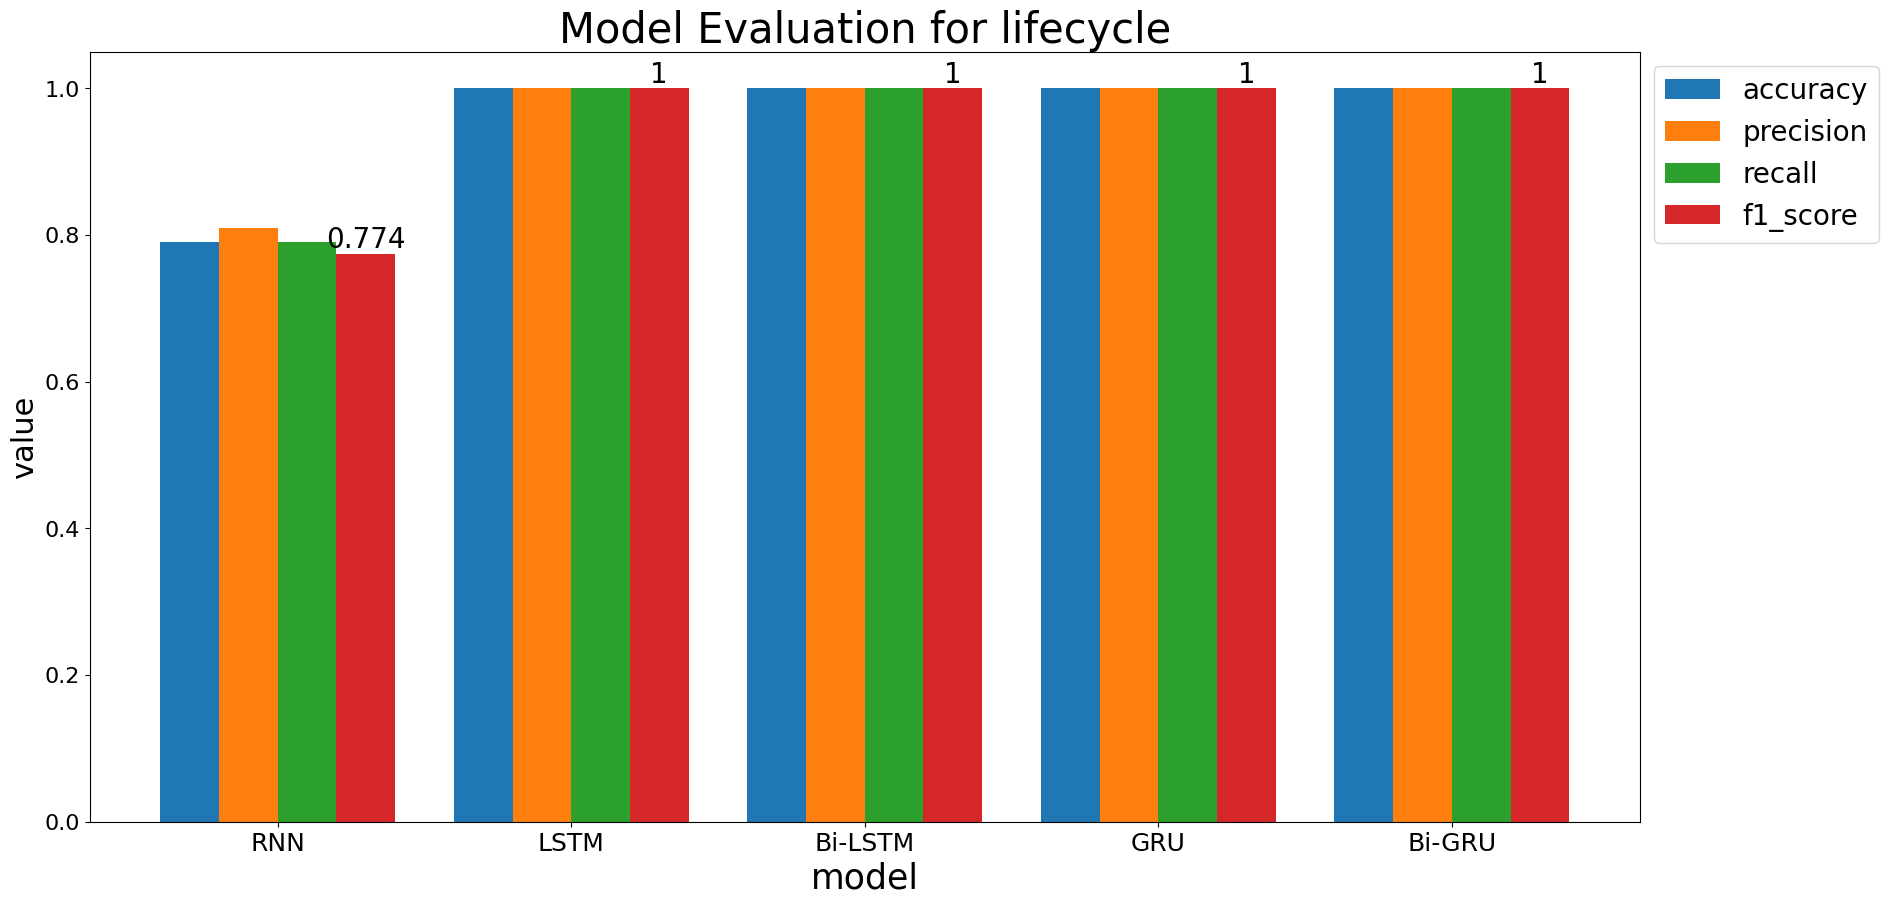

In [18]:
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for lifecycle', fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 18,
    'ytick.labelsize': 16,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.ylim(0, 1.05)
plt.show()

confusion matrix

1693
(201, 1700)
7/7 [==============================] - 1s 29ms/step


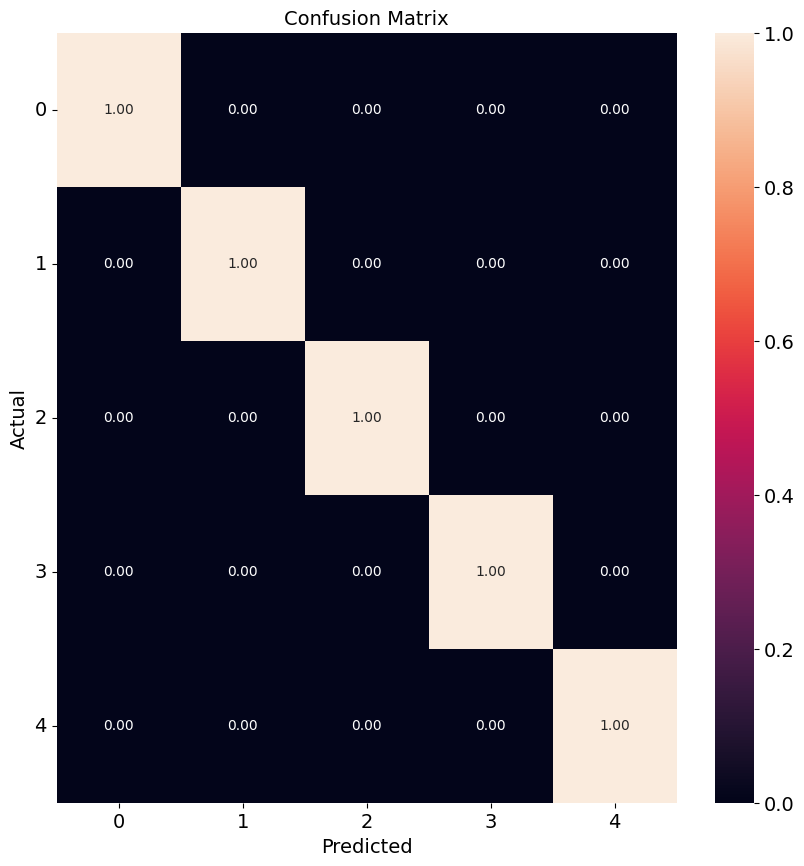

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

name = 'GRU.h5'
model_filename = os.path.join(models_folder, name)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_original

# # BERT
# model = tf.keras.models.load_model(model_filename, custom_objects={'KerasLayer': hub.KerasLayer})
# y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

# other models
model = tf.keras.models.load_model(model_filename, custom_objects=SeqSelfAttention.get_custom_objects())
X_test_tokenized = tokenizing(X_test)
y_hat = model.predict(X_test_tokenized)
y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)